# Environment Management

**Environment Name:** Mnist    
**Project Directory Name:** mnist_prj
<div style="text-align: justify">
<strong>Original Imported Libraries and Python:</strong>  
    
-python=3.11.9 (from conda-forge)  
-numpy=1.26.4 (from conda-forge)  
-matplotlib=3.9.1 (from conda-forge)  
-tensorflow==2.17.0 (from pip)  
-tensorflow-datasets==4.9.6 (from pip)  
-pandas=2.2.2 (from pip)  
    
<strong>Project Date:</strong> July 2024
</div>

In [ ]:
import sys	
sys.executable  # Display the path to the Python executable ensuring the correct env

# Import Libraries and Dataset

In [2]:
import numpy as np  # For numerical operations and arrays				
import matplotlib.pyplot as plt  # For basic plotting			
import tensorflow as tf  # For building and training ML models			
import tensorflow_datasets as tfds  # For accessing a wide range of prebuilt datasets
import pandas as pd  # For data manipulation and analysis

from Py_Scripts_Deep_Learning import batch_and_prefetch_datasets, create_image_model, train_eval_present_results, gathered_information

In [3]:
# Load the MNIST dataset using TensorFlow Datasets:
# as_supervised=True returns a tuple (image, label) instead of a dictionary with 'image' and 'label' as keys
# with_info=True returns additional information about the dataset
mnist, mnist_info = tfds.load(name='mnist', as_supervised=True, with_info = True)

# Exploration of the Dataset

In [4]:
print("Type of mnist:", type(mnist))
print("Type of mnist_info:", type(mnist_info))

Type of mnist: <class 'dict'>
Type of mnist_info: <class 'tensorflow_datasets.core.dataset_info.DatasetInfo'>


In [5]:
print(mnist.keys())

dict_keys(['train', 'test'])


In [6]:
# mnist['train'].keys()

<div style="text-align: justify">
The ‘mnist’ dictionary contains 2 keys, ‘train’ and ‘test’, which means that the dataset is already divided in train and test sets. Further exploration to check for any subkeys inside the 'train' key showed that there are no additional subkeys, which implies that 'train' is not a nested dictionary but a dataset object.
</div>

In [7]:
print(mnist['train'])

<_PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


<div style="text-align: justify">
Observing the above result and already knowing that we load the dataset as tuples of two elements we can conclude that we see two TensorSpec instances in a tuple form and each one has its shape, its dtype and an empty name. The first TensorSpec is a third-rank tensor with shape (28, 28, 1) and the second one is a zero-rank tensor of shape (). The first element is the image and the second element is the corresponding image label which is a scalar.
</div>

Label: 4


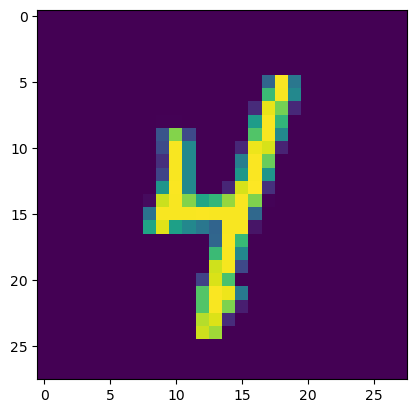

In [8]:
value = next(iter(mnist['train']))  # Retrieve a single value from the 'train' key
image, label = value  # Unpack the two element (image, label) value tuple
plt.imshow(image.numpy().squeeze())  # Show the image converting it to a numpy array and removing the third dimension
print("Label:", label.numpy())  # Convert label to numpy array and show it

<div style="text-align: justify">
From the output above, we gained a better understandig of what each tuple contains. We retrieved a single element (a dictionary value) from the 'train' key. We then unpacked this element since it is a tuple consisting of two values: an image and its label and finally printed both the image and the label on screen after converting these values to NumPy arrays.
</div>

In [9]:
# Check the lengths of each prepared set:
print('Train Set Length:', len(mnist['train']))  
print('Test Set Length:', len(mnist['test']))

Train Set Length: 60000
Test Set Length: 10000


# Data Pre Processing

In [10]:
# Assign each dictionary key to variables creating the train and test sets.
train_set, test_set = mnist['train'], mnist['test']

# Assign the train set size to a variable:
train_set_size = mnist_info.splits['train'].num_examples

# Assign the validation set size to a variable (10% of the train set size):
validation_set_size = int(train_set_size * 0.1)

# Shuffle the entire train set:
train_set = train_set.shuffle(buffer_size=train_set_size)

# Create the validation set from the shuffled train set:
validation_set = train_set.take(validation_set_size)

# Subtract the validation set from the train set:
train_set = train_set.skip(validation_set_size)

# Create a manual image scaler. Be aware to add label although it won't be used:
def scale_images(image, label):  # We add the parameter label just for format consistency
    image = tf.cast(image, tf.float32) / 255.0
    return image, label  # Having added the label, we can return a tuple to meet exactly the original dataset's format

# Apply the image scaling function to each dataset:
train_set, validation_set, test_set = (
    train_set.map(scale_images),  # The function is applied to the train set.
    validation_set.map(scale_images),  # The function is applied to the validation set.
    test_set.map(scale_images))  # The function is applied to the test set.

# Call a function which batches and prefetches the train, validation and test sets:
train_set_1, validation_set_1, test_set_1, validation_set_inputs_1, validation_set_targets_1 = batch_and_prefetch_datasets(
    train_set= train_set,
    validation_set= validation_set,
    test_set= test_set,
    batch_size=100  # Hyperparameter
)

# Deep Learning Baseline Model

<div style="text-align: justify">
For the model creation, we'll call a function that accepts several parameters. We won't call it right now, but it can be seen by opening the Py_Scripts_Deep_Learning.py file with the name 'create_image_model'. The only reason we won't call it here is because we'll call it later inside another function to achieve unbiased results. That is, the model will be relaunched at the beginning of a for loop to initialize its weights every time a run cycle begins.  
</div>

<div style="text-align: justify">
Concerning the model parameters, two of them are constants specific to the problem, while the rest are hyperparameters. A recommended approach is to use the Rectified Linear Unit (ReLU) activation function for introducing non-linearity in the hidden layers, and the softmax function for the final output layer, which produces probabilities for categorical classification. In this function, the only parameter that will vary is the list of hidden layer sizes, which is considered a hyperparameter.
</div>

# Objective Function and Optimizer

<div style="text-align: justify">
Since this is a classification problem, we will use a cross-entropy loss function. Among the available cross-entropy loss functions, `sparse_categorical_crossentropy` is appropriate because the train set labels are not one-hot encoded. For the 'metrics' parameter, we will use 'accuracy' because MNIST is well-balanced across its 10 labels, and accuracy is a commonly used metric for classification problems.
</div>

<div style="text-align: justify">
We 'll use the Adaptive Moment Estimation (Adam) optimizer, as it is one of the most advanced optimization techniques available. By keeping all other hyperparameters constant, we will evaluate if using Adam results in better accuracy. Additionally, we will test the Stochastic Gradient Descent (SGD) optimizer with momentum as another potential option for this dataset.
</div>

# Baseline Model Training & Evaluation (This is Model Number 1)

<div style="text-align: justify">
Creating and training a neural network can be complex, especially when it comes to optimizing the combination of hyperparameters. With numerous hyperparameters and their potential ranges, the number of possible combinations can be immense. This stage is often the most challenging part of the machine learning process.
</div>

<div style="text-align: justify">
While there are techniques to automate and streamline this process, we will use a manual trial-and-error approach to evaluate how different hyperparameters impact the accuracy metric. This approach will help us understand the effect of various hyperparameters on model performance.
</div>

<div style="text-align: justify">
The key function for performing unbiased test cycles, including training, validation, evaluation, and displaying the results on screen, is named 'gathered_information' and is located in the corresponding project Python file. We 'll use this function in the cell below.
</div>

In [11]:
# Define the constants and hyperparameters for the model:
INPUT_SHAPE = (28, 28, 1)  # Constant specific to this problem
OUTPUT_SIZE = 10  # Constant specific to this problem
HIDDEN_LAYER_SIZES = [50, 50]  # Hyperparameter: Number of neurons in each hidden layer
ACTIVATION_FUNCTION = 'relu'  # Hyperparameter: We 'll keep it constant
ACTIVATION_FUNCTION_OUTPUT = 'softmax'  # Hyperparameter: We 'll keep it constant
N_RANGE=10  # Number of test cycles to ensure that the evaluation metrics are correct
EPOCHS = 5  # Hyperparameter: Number of training epochs
OPTIMIZER = 'adam'  # Hyperparameter: Optimization technique
LEARNING_RATE = 0.001  # Hyperparameter: Learning rate for the above optimizer 
MOMENTUM = None  # Hyperparameter: Not used with 'adam' optimizer

# Call the function to train and evaluate the model with the specified parameters
summary_model_1 = gathered_information(
    input_shape=INPUT_SHAPE,
    output_size=OUTPUT_SIZE,
    hidden_layer_sizes=HIDDEN_LAYER_SIZES,
    activation_fun=ACTIVATION_FUNCTION,
    activation_fun_output=ACTIVATION_FUNCTION_OUTPUT,
    n_range=N_RANGE,  
    train_set=train_set_1,  # Training dataset
    validation_inputs=validation_set_inputs_1,  # Validation dataset inputs
    validation_targets=validation_set_targets_1,  # Validation dataset targets
    test_set=test_set_1,  # Test dataset
    epochs=EPOCHS,  
    optimizer=OPTIMIZER,  
    learn_rate=LEARNING_RATE,  
    mom=MOMENTUM
)

# Display the resulting DataFrame with evaluation parameters:
summary_model_1

100/100 - 0s - 1ms/step - accuracy: 0.9663 - loss: 0.1145
100/100 - 0s - 754us/step - accuracy: 0.9630 - loss: 0.1160
100/100 - 0s - 745us/step - accuracy: 0.9659 - loss: 0.1119
100/100 - 0s - 792us/step - accuracy: 0.9615 - loss: 0.1235
100/100 - 0s - 820us/step - accuracy: 0.9674 - loss: 0.1049
100/100 - 0s - 785us/step - accuracy: 0.9615 - loss: 0.1283
100/100 - 0s - 792us/step - accuracy: 0.9680 - loss: 0.1056
100/100 - 0s - 843us/step - accuracy: 0.9664 - loss: 0.1105
100/100 - 0s - 629us/step - accuracy: 0.9672 - loss: 0.1105
100/100 - 0s - 743us/step - accuracy: 0.9665 - loss: 0.1112


,Value
Number of Runs,10
Optimization Technique,adam
Average Test Accuracy,0.96537
Accuracy Standard Deviation,0.002312
Average Test Loss,0.113701
Loss Standard Deviation,0.006988


# Best Model with Adaptive Moment Estimation (Model 2)

<div style="text-align: justify">
In this section, we focus on the second model, which utilizes Adaptive Moment Estimation (Adam) as the optimization technique. The process for training and evaluating this model is identical to the baseline model, with the key difference being the hyperparameter values. Specifically, we use different hyperparameter settings to optimize the model's performance. Comments have been omitted here for brevity, as the methodology remains consistent with that of the baseline model, with adjustments only to the hyperparameters.
</div>

In [12]:
train_set_2, validation_set_2, test_set_2, validation_set_inputs_2, validation_set_targets_2 = batch_and_prefetch_datasets(
    train_set= train_set,
    validation_set= validation_set,
    test_set= test_set,
    batch_size=60
)

INPUT_SHAPE = (28, 28, 1) 
OUTPUT_SIZE = 10  
HIDDEN_LAYER_SIZES = [500, 500, 500]  
ACTIVATION_FUNCTION = 'relu'  
ACTIVATION_FUNCTION_OUTPUT = 'softmax'
N_RANGE=10 
EPOCHS = 15 
OPTIMIZER = 'adam' 
LEARNING_RATE = 0.001 
MOMENTUM = None 

summary_model_2 = gathered_information(
    input_shape=INPUT_SHAPE,
    output_size=OUTPUT_SIZE,
    hidden_layer_sizes=HIDDEN_LAYER_SIZES,
    activation_fun=ACTIVATION_FUNCTION,
    activation_fun_output=ACTIVATION_FUNCTION_OUTPUT,
    n_range=N_RANGE,  
    train_set=train_set_2, 
    validation_inputs=validation_set_inputs_2, 
    validation_targets=validation_set_targets_2, 
    test_set=test_set_2, 
    epochs=EPOCHS, 
    optimizer=OPTIMIZER, 
    learn_rate=LEARNING_RATE, 
    mom=MOMENTUM  
)

summary_model_2

167/167 - 0s - 1ms/step - accuracy: 0.9802 - loss: 0.0992
167/167 - 0s - 1ms/step - accuracy: 0.9797 - loss: 0.1062
167/167 - 0s - 1ms/step - accuracy: 0.9814 - loss: 0.1070
167/167 - 0s - 1ms/step - accuracy: 0.9814 - loss: 0.1030
167/167 - 0s - 1ms/step - accuracy: 0.9787 - loss: 0.1243
167/167 - 0s - 1ms/step - accuracy: 0.9820 - loss: 0.0915
167/167 - 0s - 1ms/step - accuracy: 0.9839 - loss: 0.0790
167/167 - 0s - 1ms/step - accuracy: 0.9753 - loss: 0.1282
167/167 - 0s - 1ms/step - accuracy: 0.9788 - loss: 0.1067
167/167 - 0s - 1ms/step - accuracy: 0.9790 - loss: 0.1087


,Value
Number of Runs,10
Optimization Technique,adam
Average Test Accuracy,0.98004
Accuracy Standard Deviation,0.002224
Average Test Loss,0.105382
Loss Standard Deviation,0.01353


# Best Model with Stochastic Gradient Descent and Momentum (Model 3)

<div style="text-align: justify">
In this section, we introduce the third model, which employs Stochastic Gradient Descent (SGD) with momentum as the optimization technique. This model follows the same training and evaluation process as the previous models, but with different hyperparameter settings specific to SGD. Momentum is included to potentially improve convergence speed and model performance. As with the previous models, detailed comments have been omitted for brevity, as the methodology remains consistent, with variations only in the hyperparameters and optimization approach.
</div>

In [22]:
INPUT_SHAPE = (28, 28, 1) 
OUTPUT_SIZE = 10  
HIDDEN_LAYER_SIZES = [600, 600, 600]  
ACTIVATION_FUNCTION = 'relu'  
ACTIVATION_FUNCTION_OUTPUT = 'softmax'
N_RANGE=10 
EPOCHS = 17 
OPTIMIZER = 'sgd' 
LEARNING_RATE = 0.0013
MOMENTUM = 0.99

summary_model_3 = gathered_information(
    input_shape=INPUT_SHAPE,
    output_size=OUTPUT_SIZE,
    hidden_layer_sizes=HIDDEN_LAYER_SIZES,
    activation_fun=ACTIVATION_FUNCTION,
    activation_fun_output=ACTIVATION_FUNCTION_OUTPUT,
    n_range=N_RANGE,  
    train_set=train_set_2, 
    validation_inputs=validation_set_inputs_2, 
    validation_targets=validation_set_targets_2, 
    test_set=test_set_2, 
    epochs=EPOCHS, 
    optimizer=OPTIMIZER, 
    learn_rate=LEARNING_RATE, 
    mom=MOMENTUM  
)

summary_model_3

167/167 - 0s - 1ms/step - accuracy: 0.9839 - loss: 0.0680
167/167 - 0s - 1ms/step - accuracy: 0.9838 - loss: 0.0671
167/167 - 0s - 1ms/step - accuracy: 0.9842 - loss: 0.0725
167/167 - 0s - 1ms/step - accuracy: 0.9844 - loss: 0.0654
167/167 - 0s - 1ms/step - accuracy: 0.9845 - loss: 0.0649
167/167 - 0s - 1ms/step - accuracy: 0.9835 - loss: 0.0701
167/167 - 0s - 1ms/step - accuracy: 0.9847 - loss: 0.0658
167/167 - 0s - 1ms/step - accuracy: 0.9839 - loss: 0.0646
167/167 - 0s - 1ms/step - accuracy: 0.9837 - loss: 0.0699
167/167 - 0s - 1ms/step - accuracy: 0.9844 - loss: 0.0658


,Value
Number of Runs,10
Optimization Technique,sgd
Average Test Accuracy,0.9841
Accuracy Standard Deviation,0.000374
Average Test Loss,0.067417
Loss Standard Deviation,0.002525


# Conclusions

<div style="text-align: justify">
This project aimed to evaluate and compare different optimization techniques for training a neural network model for image classification. Specifically, it focused on assessing the performance of the baseline Adam optimizer, a tuned Adam optimizer, and the SGD optimizer. The key metrics used for comparison were average test accuracy, accuracy standard deviation, average test loss, and loss standard deviation.
</div>

<div style="text-align: justify">
The model trained with the SGD optimizer outperformed both the baseline and tuned Adam models. It achieved the highest average test accuracy of 0.9841 and the lowest average test loss of 0.067417. Additionally, the accuracy and loss standard deviations were lower for SGD, indicating more stable and consistent performance across the runs.
</div>